In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [2]:
img_folder_path = r"C:\Users\varda\OneDrive\Desktop\Case Study\Group_7_wet_severe\Group_7_wet_severe"

In [3]:
road_classes = ['wet_asphalt_severe', 'wet_concrete_severe', 'wet_gravel']

In [4]:
import os
import pandas as pd

img_list = []
classes_list = []

for road in road_classes:
    for img_file in os.listdir(img_folder_path+'/train/'+road):
        img_list.append(img_folder_path+'/train/'+road+'/'+img_file)
        classes_list.append(road)
        
train_df = pd.DataFrame({'img':img_list, 'class':classes_list})

In [5]:
train_df.head()

,img,class
0,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe
1,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe
2,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe
3,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe
4,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe


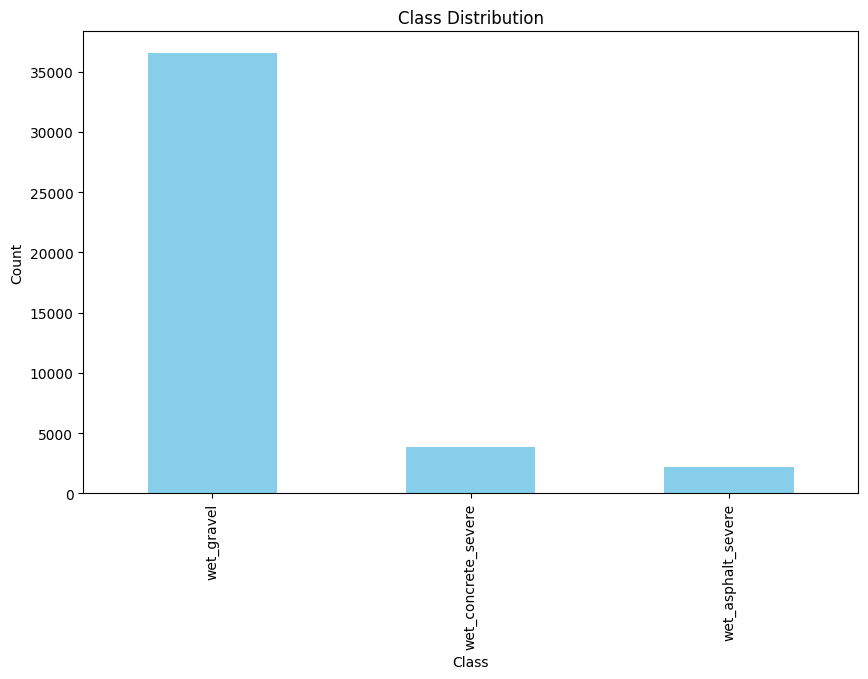

In [6]:
import matplotlib.pyplot as plt

# Assuming 'class' is the column containing class labels in your DataFrame
class_distribution = train_df['class'].value_counts()

# Plotting the class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [7]:
wet_gravel_df = train_df[train_df['class'] == 'wet_gravel']
wet_concrete_severe_df = train_df[train_df['class'] == 'wet_concrete_severe']
wet_asphalt_severe_df = train_df[train_df['class'] == 'wet_asphalt_severe']

# Undersample the majority class (wet_gravel)
undersampled_wet_gravel_df = wet_gravel_df.sample(n=len(wet_concrete_severe_df), replace=False, random_state=42)

# Concatenate the undersampled majority class with the minority classes
undersampled_df = pd.concat([undersampled_wet_gravel_df, wet_concrete_severe_df, wet_asphalt_severe_df])

# Shuffle the undersampled DataFrame
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [8]:
undersampled_df['class'].value_counts()

class
wet_gravel             3854
wet_concrete_severe    3854
wet_asphalt_severe     2161
Name: count, dtype: int64

In [9]:
# Create a dataframe for mapping label
dict_class = {
    'wet_asphalt_severe' : 0,
    'wet_concrete_severe' : 1,
    'wet_gravel' : 2
}

In [10]:
# Encode
undersampled_df['encoded_class'] = undersampled_df['class'].map(dict_class)
undersampled_df.head()

,img,class,encoded_class
0,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2
1,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2
2,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe,0
3,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe,0
4,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2


In [11]:
X_train= []
for img in undersampled_df['img']:
    img = cv2.imread(str(img))
    #img = augment_function(img)
    img = cv2.resize(img, (96, 96))
    img = img/255
    X_train.append(img)

In [12]:
y_train = undersampled_df['encoded_class']

In [13]:
#validation
img_list = []
classes_list = []

for road in road_classes:
    for img_file in os.listdir(img_folder_path+'/valid/'+road):
        img_list.append(img_folder_path+'/valid/'+road+'/'+img_file)
        classes_list.append(road)
        
valid_df = pd.DataFrame({'img':img_list, 'class':classes_list})

In [14]:
valid_df['class'].value_counts()

class
wet_gravel             821
wet_asphalt_severe     251
wet_concrete_severe    251
Name: count, dtype: int64

In [15]:
wet_gravel_df = valid_df[valid_df['class'] == 'wet_gravel']
wet_concrete_severe_df = valid_df[valid_df['class'] == 'wet_concrete_severe']
wet_asphalt_severe_df = valid_df[valid_df['class'] == 'wet_asphalt_severe']

# Undersample the majority class (wet_gravel)
undersampled_wet_gravel_df = wet_gravel_df.sample(n=len(wet_concrete_severe_df), replace=False, random_state=42)

# Concatenate the undersampled majority class with the minority classes
undersampled_df = pd.concat([undersampled_wet_gravel_df, wet_concrete_severe_df, wet_asphalt_severe_df])

# Shuffle the undersampled DataFrame
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
undersampled_df['class'].value_counts()

class
wet_asphalt_severe     251
wet_concrete_severe    251
wet_gravel             251
Name: count, dtype: int64

In [17]:
# Encode
undersampled_df['encoded_class'] = undersampled_df['class'].map(dict_class)
undersampled_df.head()

,img,class,encoded_class
0,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe,0
1,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe,0
2,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_concrete_severe,1
3,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2
4,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2


In [18]:
X_valid = []
y_valid = []

for idx in range(len(undersampled_df)):
    img = cv2.imread(str(undersampled_df.iloc[idx, 0]))
    if img is None:
        pass
    else:
        img = cv2.resize(img, (96, 96))
        img = img/255
        X_valid.append(img)
        y_valid.append(undersampled_df.iloc[idx, 2])

In [19]:
#test

In [20]:
img_list = []
classes_list = []

for road in road_classes:
    for img_file in os.listdir(img_folder_path+'/test/'+road):
        img_list.append(img_folder_path+'/test/'+road+'/'+img_file)
        classes_list.append(road)
        
test_df = pd.DataFrame({'img':img_list, 'class':classes_list})

In [21]:
test_df['class'].value_counts()

class
wet_gravel             2351
wet_asphalt_severe      801
wet_concrete_severe     801
Name: count, dtype: int64

In [22]:
wet_gravel_df = test_df[test_df['class'] == 'wet_gravel']
wet_concrete_severe_df = test_df[test_df['class'] == 'wet_concrete_severe']
wet_asphalt_severe_df = test_df[test_df['class'] == 'wet_asphalt_severe']

# Undersample the majority class (wet_gravel)
undersampled_wet_gravel_df = wet_gravel_df.sample(n=len(wet_concrete_severe_df), replace=False, random_state=42)

# Concatenate the undersampled majority class with the minority classes
undersampled_df = pd.concat([undersampled_wet_gravel_df, wet_concrete_severe_df, wet_asphalt_severe_df])

# Shuffle the undersampled DataFrame
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [23]:
# Encode
undersampled_df['encoded_class'] = undersampled_df['class'].map(dict_class)
undersampled_df.head()

,img,class,encoded_class
0,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2
1,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe,0
2,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2
3,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2
4,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2


In [24]:
X_test = []
y_test = []

for idx in range(len(undersampled_df)):
    img = cv2.imread(str(undersampled_df.iloc[idx, 0]))
    if img is None:
        pass
    else:
        img = cv2.resize(img, (96, 96))
        img = img/255
        X_test.append(img)
        y_test.append(undersampled_df.iloc[idx, 2])

In [25]:
# Encode
undersampled_df['encoded_class'] = undersampled_df['class'].map(dict_class)
undersampled_df.head()

,img,class,encoded_class
0,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2
1,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_asphalt_severe,0
2,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2
3,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2
4,C:\Users\varda\OneDrive\Desktop\Case Study\Gro...,wet_gravel,2


In [26]:
#!pip install efficientnet


In [27]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from efficientnet.tfkeras import EfficientNetB0


# Load pre-trained EfficientNetV2 model

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96,96,3))

base_model.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 48, 48, 32)   0           ['stem_bn[0][0]']                
                                                                                    

In [28]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
road_classes=3
model = Sequential()
model.add(Input(shape=(96,96,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 3, 3, 1280)       4049564   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 3)                 34563     
                                                                 
Total params: 4,084,127
Trainable params: 4,042,111
Non-trainable params: 42,016
_________________________________________________________________


In [29]:
model.compile(
  optimizer="adam",
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

history = model.fit(np.array(X_train), np.array(y_train), epochs=100, batch_size = 32, validation_data=(np.array(X_valid), np.array(y_valid)))

Epoch 1/100
309/309 [==============================] - 42s 85ms/step - loss: 0.4786 - acc: 0.8321 - val_loss: 2.3559 - val_acc: 0.6977
Epoch 2/100
309/309 [==============================] - 25s 80ms/step - loss: 0.2768 - acc: 0.9065 - val_loss: 0.4345 - val_acc: 0.8682
Epoch 3/100
309/309 [==============================] - 25s 80ms/step - loss: 0.2245 - acc: 0.9237 - val_loss: 0.2344 - val_acc: 0.9134
Epoch 4/100
309/309 [==============================] - 25s 81ms/step - loss: 0.4010 - acc: 0.9037 - val_loss: 1.0858 - val_acc: 0.8282
Epoch 5/100
309/309 [==============================] - 25s 81ms/step - loss: 0.2390 - acc: 0.9221 - val_loss: 0.2464 - val_acc: 0.9254
Epoch 6/100
309/309 [==============================] - 25s 81ms/step - loss: 0.1638 - acc: 0.9438 - val_loss: 0.3136 - val_acc: 0.9108
Epoch 7/100
309/309 [==============================] - 25s 81ms/step - loss: 0.1241 - acc: 0.9593 - val_loss: 0.3696 - val_acc: 0.9334
Epoch 8/100
309/309 [==============================] - 

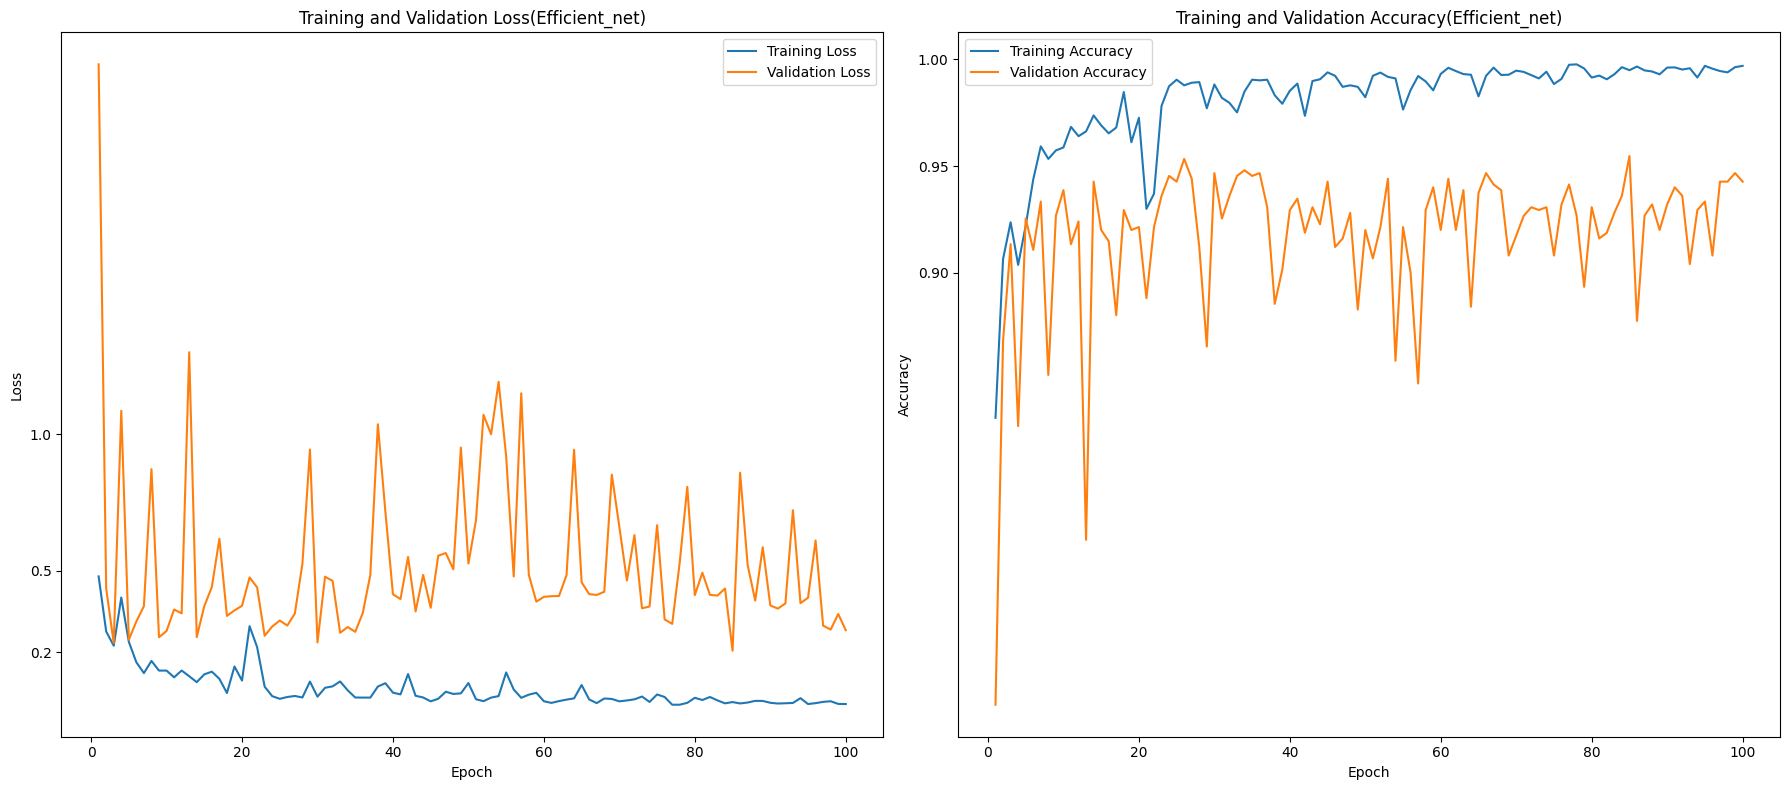

In [30]:
import matplotlib.pyplot as plt

# Access the complete training history
full_history = history.history

# Plotting the training loss and validation loss
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(full_history['loss']) + 1), full_history['loss'], label='Training Loss')
plt.plot(range(1, len(full_history['val_loss']) + 1), full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss(Efficient_net)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([0.2, 0.5, 1.0])  # Set custom y-axis ticks for loss
plt.legend()

# Plotting the training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(full_history['acc']) + 1), full_history['acc'], label='Training Accuracy')
plt.plot(range(1, len(full_history['val_acc']) + 1), full_history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy(Efficient_net)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([0.9, 0.95, 1.0])  # Set custom y-axis ticks for accuracy
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
model.save("EfficientnetB0.h5")

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Layer, Dropout

class FixedDropout(Dropout):
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super(FixedDropout, self).__init__(rate, noise_shape=noise_shape, seed=seed, **kwargs)

    def call(self, inputs, training=None):
        if training is None:
            training = True
        if not training:
            return inputs
        return super(FixedDropout, self).call(inputs, training=training)

# Provide custom_objects argument when loading the model
model = load_model("C:\\Users\\varda\\OneDrive\\Desktop\\Case Study\\EfficientnetB0.h5", custom_objects={'FixedDropout': FixedDropout})


In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

print("EfficientnetB0")
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score:", f1)

# Precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)


recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall:", recall)


76/76 [==============================] - 2s 18ms/step
EfficientnetB0
Accuracy: 0.9537692628071637
F1 Score: 0.9538660641255505
Precision: 0.9547173753109593
Recall: 0.9537692628071637


In [34]:
Y_pred_cls = np.argmax(model.predict(np.array(X_test)), axis = -1)

76/76 [==============================] - 1s 18ms/step


In [35]:
#attention mechanism

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D, Activation, Multiply, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from efficientnet.tfkeras import EfficientNetB0

from tensorflow.keras.layers import LeakyReLU

num_classes = 3

def spatial_attention(input_feature, filters=64, kernel_size=2, dropout_rate=0.5):
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_feature)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Dropout(dropout_rate)(x)
    
    x = Conv2D(filters//2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    x = Activation('softmax')(x)
    
    return Multiply()([input_feature, x])

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

att_layer = spatial_attention(base_model.layers[100].output)

att_max_pooling = MaxPooling2D(pool_size=(2, 2))(att_layer)

gap = GlobalAveragePooling2D()(att_max_pooling)

dropout = Dropout(0.5)(gap)

output = Dense(num_classes, activation='softmax')(dropout)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    np.array(X_train),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(np.array(X_valid), np.array(y_valid))
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 stem_conv (Conv2D)             (None, 48, 48, 32)   864         ['input_3[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 48, 48, 32)   128         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activation)   (None, 48, 48, 32)   0           ['stem_bn[0][0]']                
                                                                                              

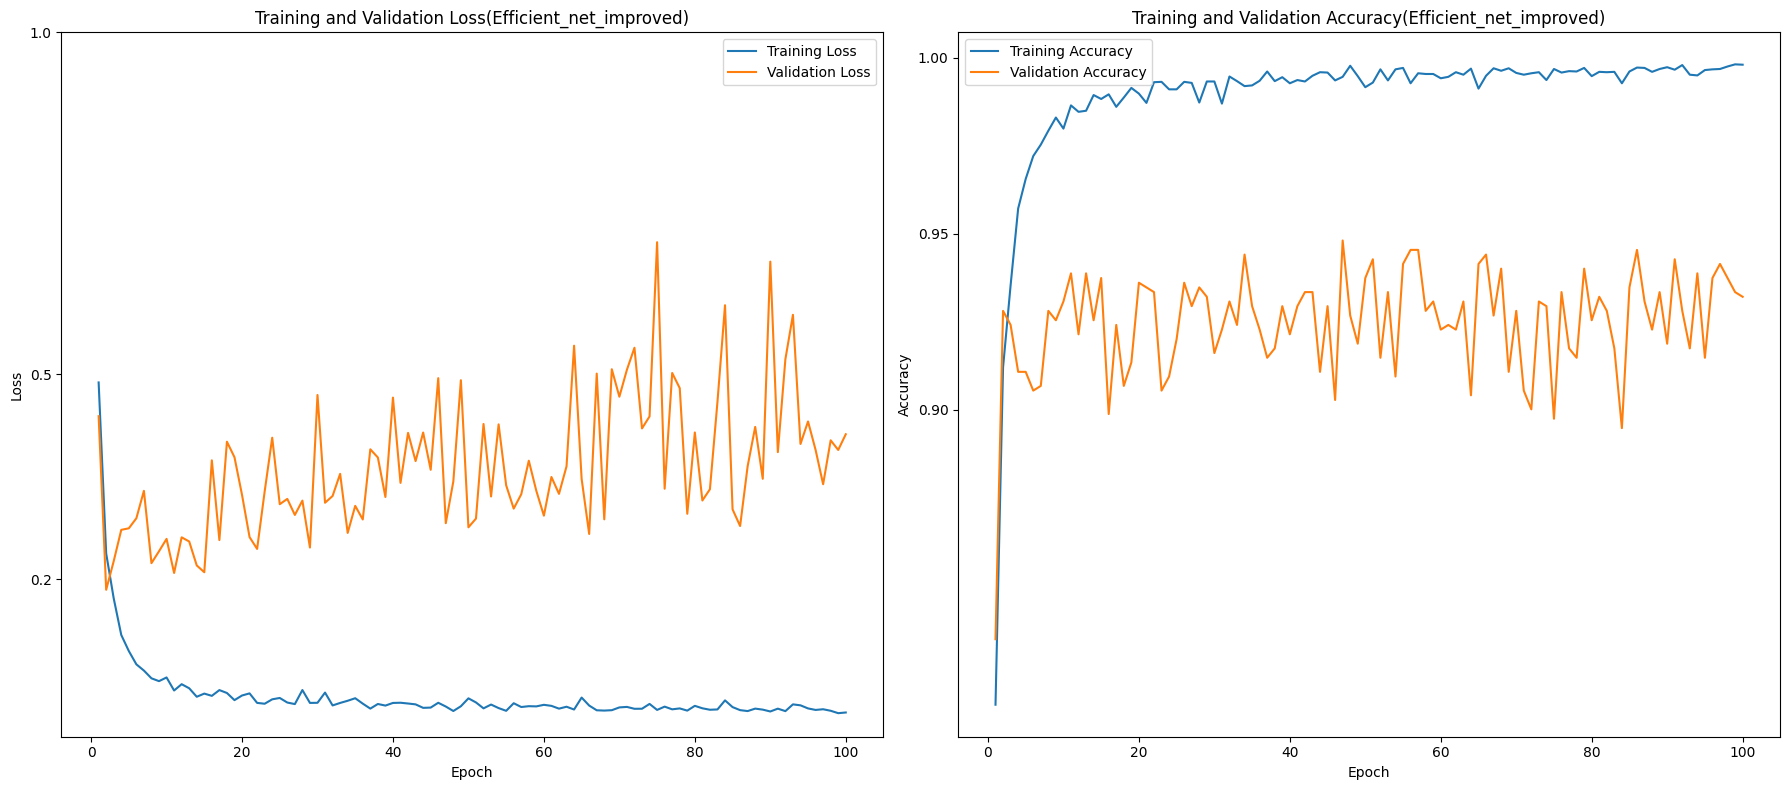

In [37]:
import matplotlib.pyplot as plt

full_history = history.history

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(full_history['loss']) + 1), full_history['loss'], label='Training Loss')
plt.plot(range(1, len(full_history['val_loss']) + 1), full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss(Efficient_net_improved)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([0.2, 0.5, 1.0])  
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(full_history['accuracy']) + 1), full_history['accuracy'], label='Training Accuracy')
plt.plot(range(1, len(full_history['val_accuracy']) + 1), full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy(Efficient_net_improved)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([0.9, 0.95, 1.0])  
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
model.save("Efficient_net_improved.h5")

In [ ]:
model = load_model("Efficient_net_improved.h5")

In [40]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

print("Improved EfficientNetb0")
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score:", f1)

# Precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall:", recall)

76/76 [==============================] - 2s 16ms/step
Improved EfficientNetb0
Accuracy: 0.9512703040399834
F1 Score: 0.951310250779925
Precision: 0.9513736514593757
Recall: 0.9512703040399834


In [41]:
#Densenet121

In [42]:
from tensorflow.keras.applications import DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(96,96,3))
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 102, 102, 3)  0          ['input_4[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']             
                                                                                        

In [43]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
road_classes=3
model = Sequential()
model.add(Input(shape=(96,96,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 27651     
                                                                 
Total params: 7,065,155
Trainable params: 6,981,507
Non-trainable params: 83,648
_________________________________________________________________


In [44]:
model.compile(
  optimizer="adam",
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

history = model.fit(np.array(X_train), np.array(y_train), epochs=100, batch_size = 32, validation_data=(np.array(X_valid), np.array(y_valid)))

Epoch 1/100
309/309 [==============================] - 64s 169ms/step - loss: 1.2258 - acc: 0.6918 - val_loss: 109.7887 - val_acc: 0.3342
Epoch 2/100
309/309 [==============================] - 51s 163ms/step - loss: 1.1759 - acc: 0.5696 - val_loss: 4.5110 - val_acc: 0.4660
Epoch 3/100
309/309 [==============================] - 51s 164ms/step - loss: 1.0985 - acc: 0.6089 - val_loss: 11997.0693 - val_acc: 0.3515
Epoch 4/100
309/309 [==============================] - 51s 164ms/step - loss: 0.9356 - acc: 0.6358 - val_loss: 2.7226 - val_acc: 0.3782
Epoch 5/100
309/309 [==============================] - 51s 164ms/step - loss: 0.9127 - acc: 0.6639 - val_loss: 23.6658 - val_acc: 0.5792
Epoch 6/100
309/309 [==============================] - 50s 163ms/step - loss: 0.8746 - acc: 0.6848 - val_loss: 1.1494 - val_acc: 0.5726
Epoch 7/100
309/309 [==============================] - 50s 163ms/step - loss: 0.8954 - acc: 0.6975 - val_loss: 3.4862 - val_acc: 0.4261
Epoch 8/100
309/309 [====================

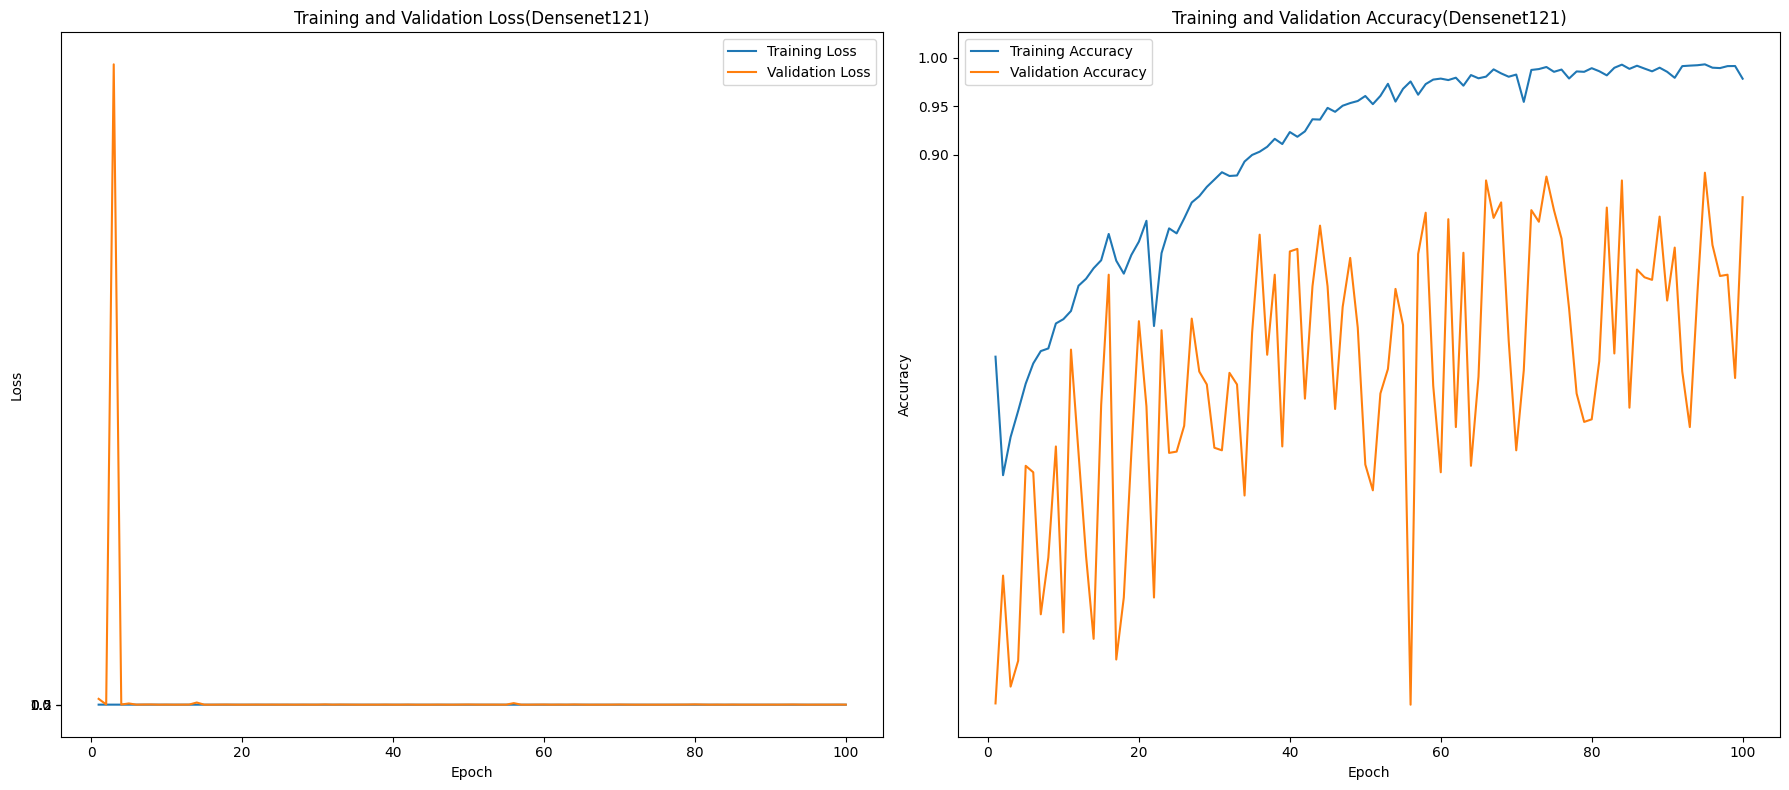

In [45]:
full_history = history.history

# Plotting the training loss and validation loss
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(full_history['loss']) + 1), full_history['loss'], label='Training Loss')
plt.plot(range(1, len(full_history['val_loss']) + 1), full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss(Densenet121)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([0.2, 0.5, 1.0])  # Set custom y-axis ticks for loss
plt.legend()

# Plotting the training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(full_history['acc']) + 1), full_history['acc'], label='Training Accuracy')
plt.plot(range(1, len(full_history['val_acc']) + 1), full_history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy(Densenet121)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([0.9, 0.95, 1.0])  # Set custom y-axis ticks for accuracy
plt.legend()

plt.tight_layout()
plt.show()


In [46]:
model.save("Densenet121.h5")

In [47]:
model = load_model("Efficient_net_improved.h5")

In [48]:
y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

print("Densenet121")
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score:", f1)

# Precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall:", recall)

76/76 [==============================] - 2s 17ms/step
Densenet121
Accuracy: 0.9512703040399834
F1 Score: 0.951310250779925
Precision: 0.9513736514593757
Recall: 0.9512703040399834


In [49]:
#attention mechanism

In [50]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

att_layer = spatial_attention(base_model.layers[100].output)


att_max_pooling = MaxPooling2D(pool_size=(2, 2))(att_layer)

gap = GlobalAveragePooling2D()(att_max_pooling)

# Dropout layer for regularization
dropout = Dropout(0.5)(gap)

# Output layer
output = Dense(num_classes, activation='softmax')(dropout)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    np.array(X_train),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(np.array(X_valid), np.array(y_valid))
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 102, 102, 3)  0          ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 48, 48, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1/conv[0][0]']       

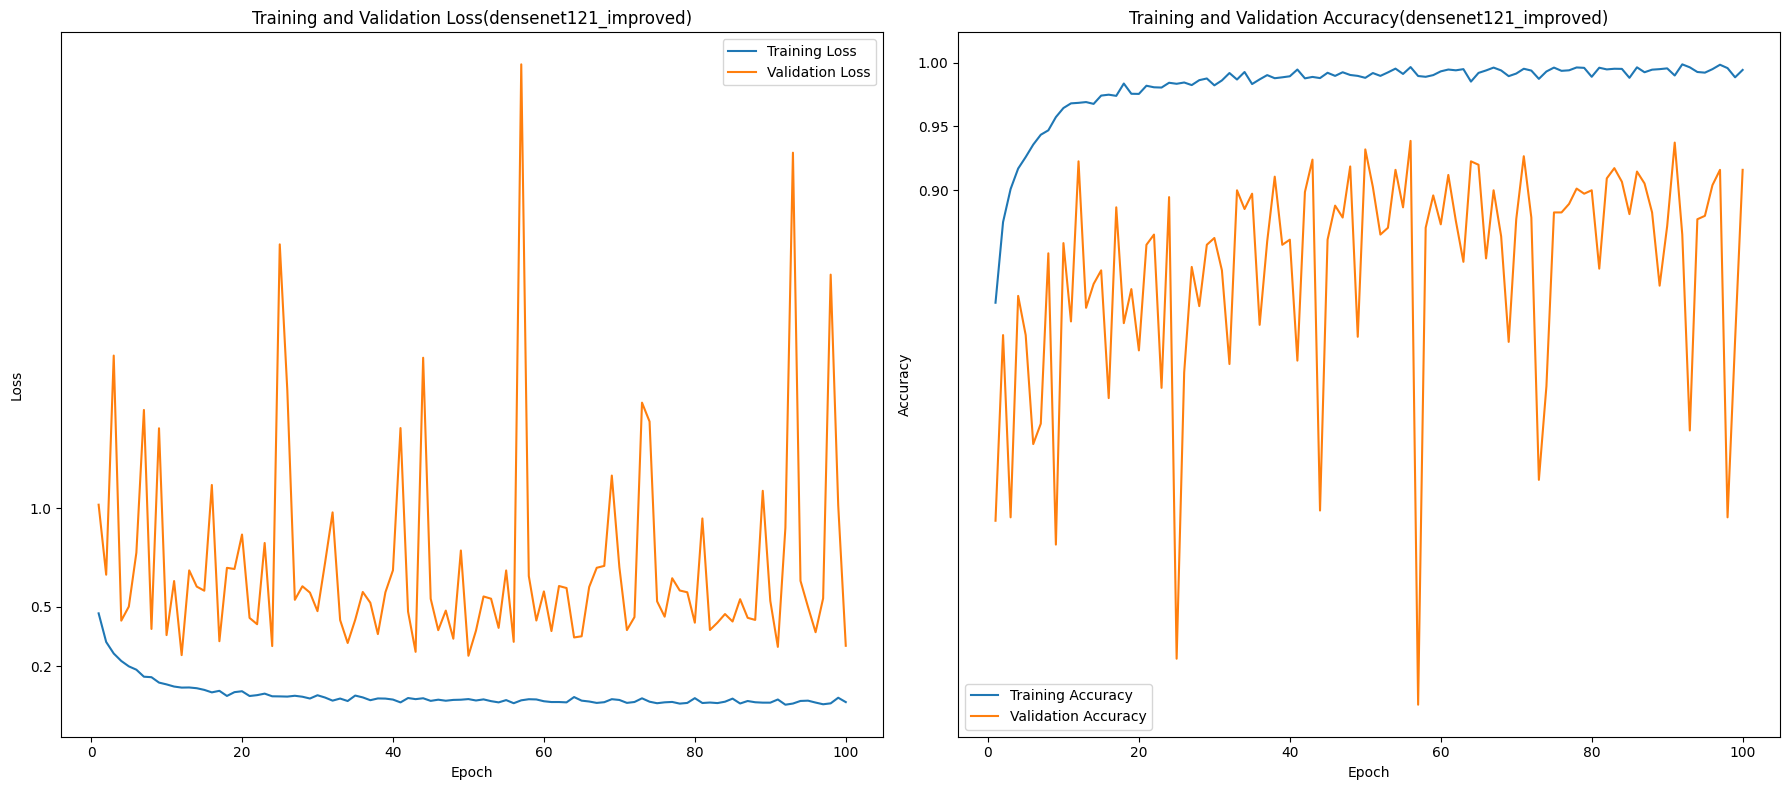

In [51]:

full_history = history.history

# Plotting the training loss and validation loss
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(full_history['loss']) + 1), full_history['loss'], label='Training Loss')
plt.plot(range(1, len(full_history['val_loss']) + 1), full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss(densenet121_improved)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([0.2, 0.5, 1.0])  # Set custom y-axis ticks for loss
plt.legend()

# Plotting the training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(full_history['accuracy']) + 1), full_history['accuracy'], label='Training Accuracy')
plt.plot(range(1, len(full_history['val_accuracy']) + 1), full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy(densenet121_improved)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([0.9, 0.95, 1.0])  # Set custom y-axis ticks for accuracy
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
model.save("densenet121_improved.h5")

In [3]:

model = load_model("densenet121_improved.h5")

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Assuming you already have predictions for X_test
y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score:", f1)

# Precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall:", recall)

76/76 [==============================] - 2s 20ms/step
Accuracy: 0.920033319450229
F1 Score: 0.9196012607852023
Precision: 0.9208160783913788
Recall: 0.920033319450229


In [55]:
#Vgg16

In [56]:
from keras.applications import VGG16
base_model = VGG16(input_shape = (96,96,3), include_top = False, weights = 'imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [58]:

model = Sequential()
model.add(Input(shape=(96,96,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 13827     
                                                                 
Total params: 14,728,515
Trainable params: 14,728,515
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(
  optimizer="adam",
  loss='sparse_categorical_crossentropy',
  metrics=['acc'])

history = model.fit(np.array(X_train), np.array(y_train), epochs=100, batch_size = 32, validation_data=(np.array(X_valid), np.array(y_valid)))

Epoch 1/100
309/309 [==============================] - 56s 161ms/step - loss: 0.9466 - acc: 0.5519 - val_loss: 0.7981 - val_acc: 0.5752
Epoch 2/100
309/309 [==============================] - 46s 150ms/step - loss: 0.6957 - acc: 0.6604 - val_loss: 0.6679 - val_acc: 0.6099
Epoch 3/100
309/309 [==============================] - 46s 149ms/step - loss: 0.6118 - acc: 0.7192 - val_loss: 0.6428 - val_acc: 0.7097
Epoch 4/100
309/309 [==============================] - 46s 149ms/step - loss: 0.5592 - acc: 0.7585 - val_loss: 0.5117 - val_acc: 0.7936
Epoch 5/100
309/309 [==============================] - 46s 149ms/step - loss: 0.4821 - acc: 0.7970 - val_loss: 0.5033 - val_acc: 0.7989
Epoch 6/100
309/309 [==============================] - 46s 149ms/step - loss: 0.4163 - acc: 0.8309 - val_loss: 0.7308 - val_acc: 0.7230
Epoch 7/100
309/309 [==============================] - 46s 149ms/step - loss: 0.3939 - acc: 0.8488 - val_loss: 0.6167 - val_acc: 0.7510
Epoch 8/100
309/309 [===========================

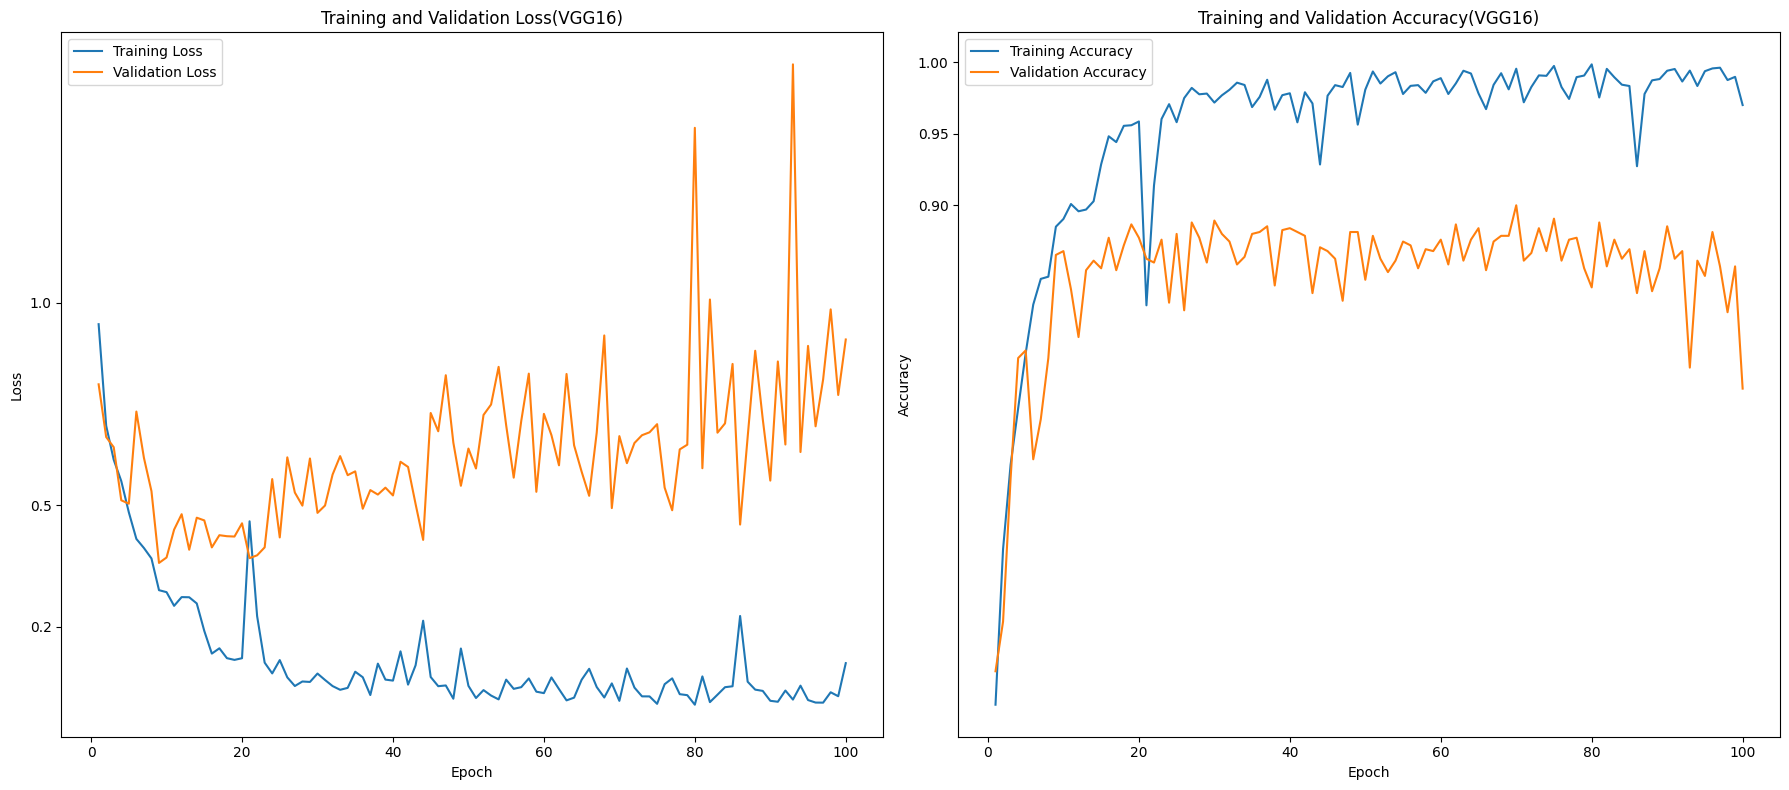

In [60]:
full_history = history.history

# Plotting the training loss and validation loss
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(full_history['loss']) + 1), full_history['loss'], label='Training Loss')
plt.plot(range(1, len(full_history['val_loss']) + 1), full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss(VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([0.2, 0.5, 1.0])  # Set custom y-axis ticks for loss
plt.legend()

# Plotting the training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(full_history['acc']) + 1), full_history['acc'], label='Training Accuracy')
plt.plot(range(1, len(full_history['val_acc']) + 1), full_history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy(VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([0.9, 0.95, 1.0])  # Set custom y-axis ticks for accuracy
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input ,Conv2D, Activation, Multiply, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import LeakyReLU
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


def spatial_attention(input_feature, filters=64, kernel_size=2, dropout_rate=0.5):
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_feature)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Dropout(dropout_rate)(x)
    
    x = Conv2D(filters//2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    x = Activation('softmax')(x)
    
    return Multiply()([input_feature, x])

In [61]:
model.save("VGG16.h5")

In [32]:
model = load_model("VGG16.h5")

In [33]:
y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

print("VGG16")
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score:", f1)

# Precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall:", recall)

76/76 [==============================] - 3s 41ms/step
VGG16
Accuracy: 0.7817576009995835
F1 Score: 0.7817766814544667
Precision: 0.8004299916651928
Recall: 0.7817576009995835


In [36]:
from keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Add enhanced spatial attention mechanism after a specific convolutional layer
att_layer = spatial_attention(base_model.layers[10].output)

# Add max pooling layer
att_max_pooling = MaxPooling2D(pool_size=(2, 2))(att_layer)

gap = GlobalAveragePooling2D()(att_max_pooling)

# Dropout layer for regularization
dropout = Dropout(0.5)(gap)

# Output layer
output = Dense(3, activation='softmax')(dropout)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 96, 96, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 96, 96, 64)   36928       ['block1_conv1[0][0]']           
                                                                                                  
 block1_pool (MaxPooling2D)     (None, 48, 48, 64)   0           ['block1_conv2[0][0]']           
                                                                                              

In [37]:
history = model.fit(
    np.array(X_train),
    np.array(y_train),
    epochs=100,
    batch_size=32,
    validation_data=(np.array(X_valid), np.array(y_valid))
)

Epoch 1/100
309/309 [==============================] - 43s 121ms/step - loss: 1.2907 - accuracy: 0.5412 - val_loss: 0.7344 - val_accuracy: 0.6085
Epoch 2/100
309/309 [==============================] - 34s 111ms/step - loss: 0.6536 - accuracy: 0.7176 - val_loss: 0.6241 - val_accuracy: 0.7164
Epoch 3/100
309/309 [==============================] - 35s 113ms/step - loss: 0.5195 - accuracy: 0.7814 - val_loss: 0.4625 - val_accuracy: 0.7870
Epoch 4/100
309/309 [==============================] - 35s 113ms/step - loss: 0.4342 - accuracy: 0.8237 - val_loss: 0.3525 - val_accuracy: 0.8575
Epoch 5/100
309/309 [==============================] - 35s 114ms/step - loss: 0.3645 - accuracy: 0.8563 - val_loss: 0.3270 - val_accuracy: 0.8708
Epoch 6/100
309/309 [==============================] - 35s 113ms/step - loss: 0.3258 - accuracy: 0.8710 - val_loss: 0.4928 - val_accuracy: 0.8056
Epoch 7/100
309/309 [==============================] - 34s 111ms/step - loss: 0.2904 - accuracy: 0.8871 - val_loss: 0.4958 -

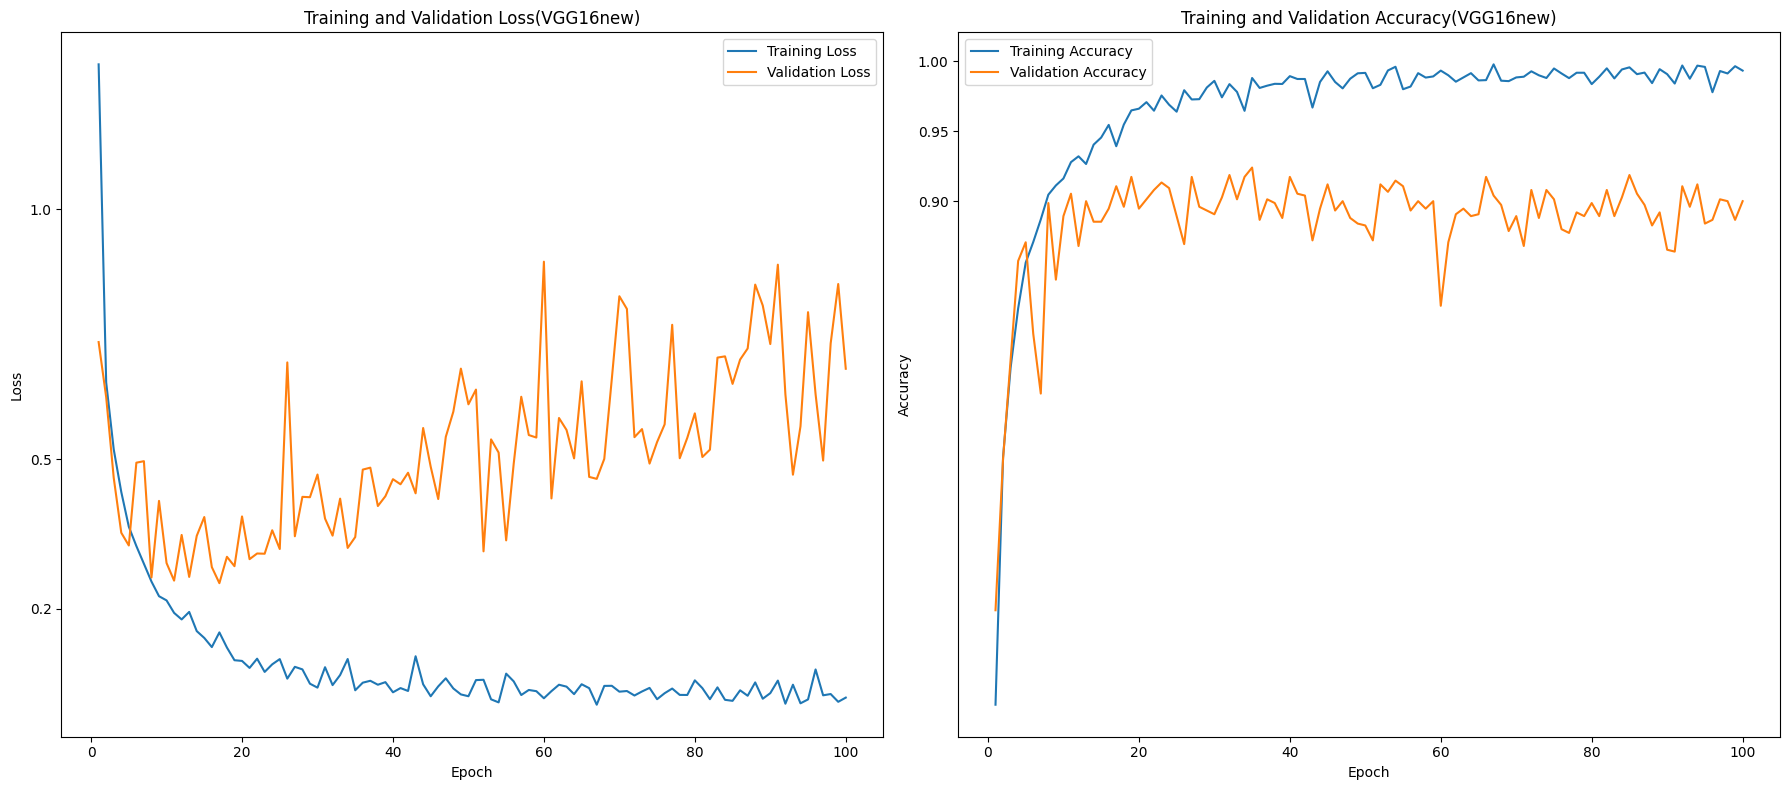

In [38]:
full_history = history.history

# Plotting the training loss and validation loss
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(full_history['loss']) + 1), full_history['loss'], label='Training Loss')
plt.plot(range(1, len(full_history['val_loss']) + 1), full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss(VGG16new)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks([0.2, 0.5, 1.0])  # Set custom y-axis ticks for loss
plt.legend()

# Plotting the training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(full_history['accuracy']) + 1), full_history['accuracy'], label='Training Accuracy')
plt.plot(range(1, len(full_history['val_accuracy']) + 1), full_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy(VGG16new)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yticks([0.9, 0.95, 1.0])  # Set custom y-axis ticks for accuracy
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
model.save("VGG16New.h5")

In [40]:
model = load_model("VGG16New.h5")

In [41]:
y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score:", f1)

# Precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall:", recall)

76/76 [==============================] - 3s 33ms/step
Accuracy: 0.8967097042898792
F1 Score: 0.8969451442211087
Precision: 0.900893395401751
Recall: 0.8967097042898792
